<a href="https://colab.research.google.com/github/rrajevan/techlab_motionminer_test/blob/main/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import json
import pickle
import seaborn as sns
from matplotlib import pyplot as plt

from google.colab import drive # for running on Google Colab
drive.mount('/content/drive') # for running on Google Colab

Mounted at /content/drive


In [15]:
constant = {
    "region_flow_dict": {
        "region_name": [
            "Not in use",
            "Pre-checkin",
            "Waiting Checkin",
            "Checkin Main",
            "Waiting I",
            "Doctor Table",
            "Vaccination",
            "Waiting II",
            "Checkout",
            "Waiting III",
        ],
        "region_id": [
            1,
            [2, 5],
            90,
            [3, 4],
            91,
            [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
            [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
            92,
            [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41],
            93,
        ],
        "flow_id": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    },
    "txpower_vs_distance": {
        "Distance(m)": [0, 1, 3, 5, 10, 15, 20, 30, 40, 50],
        "-30(dBm)": [
            -63,
            -92,
            -99,
            -101,
            np.nan,
            np.nan,
            np.nan,
            np.nan,
            np.nan,
            np.nan,
        ],
        "-20(dBm)": [-47, -79, -84, -90, -95, -98, -102, np.nan, np.nan, np.nan],
        "-16(dBm)": [-42, -71, -82, -88, -95, -97, -102, np.nan, np.nan, np.nan],
        "-12(dBm)": [-40, -68, -74, -84, -89, -95, -97, -102, np.nan, np.nan],
        "-8(dBm)": [-40, -66, -73, -82, -87, -92, -94, -96, -99, -102],
        "-4(dBm)": [-34, -58, -70, -74, -81, -90, -92, -93, -99, -102],
        "0(dBm)": [-27, -59, -67, -71, -79, -84, -87, -92, -94, -100],
        "4(dBm)": [-2, -57, -62, -67, -75, -82, -85, -88, -91, -99],
    },
};

In [150]:
def create_mapped_layout(layout_path):
    """
    Create a completed layout has beacons, regions and flows

    Parameters
    ----------
    layout_path: str
        path of layout file

    Returns
    -------
    pandas.DataFrame
        a dataframe of beacons, regions and flows
    """
    with open(layout_path, "r") as layout_file:
        layout = json.load(layout_file)
        beacons_layout = pd.DataFrame.from_dict(layout["beacons"])
        regions_layout = pd.DataFrame.from_dict(layout["regions"])

    beacons_regions_layout = beacons_layout.merge(
        regions_layout, left_on="region_uuid", right_on="uuid"
    )

    beacons_regions_layout.rename(
        columns={
            "id_x": "beacon_id",
            "id_y": "region_id",
            "name": "region_name",
            "position_x": "b_pos_x",
            "position_y": "b_pos_y",
            "position_top_left_x": "rpos_top_left_x",
            "position_top_left_y": "rpos_top_left_y",
            "position_bottom_right_x": "rpos_bottom_right_x",
            "position_bottom_right_y": "rpos_bottom_right_y",
        },
        inplace=True,
    )
    beacons_regions_layout["region_beacon"] = (
        beacons_regions_layout["region_id"].astype(str)
        + "_"
        + beacons_regions_layout["beacon_id"].astype(str)
    )

    region_flow_df = pd.DataFrame.from_dict(data=constant["region_flow_dict"])
    exploded_region_flow_df = region_flow_df.explode("region_id")

    final_layout = beacons_regions_layout.merge(
        exploded_region_flow_df, left_on="region_id", right_on="region_id"
    )
    final_layout["flow_beacon"] = (
        final_layout["flow_id"].astype(str)
        + "_"
        + final_layout["beacon_id"].astype(str)
    )

    return final_layout


def get_flow_of_beacon(layout):
    """
    Determine the flow id which beacon belongs to

    Parameters
    ----------
    layout: pandas.DataFrame
        the layout has mapped beacons, regions and flows

    Returns
    -------
    pandas.DataFrame
        a dataframe of beacons and its corresponding flow id
    """
    beacons_with_flow = layout.loc[
        :, ["beacon_id", "flow_id"]
    ]  # only the beacon and flow region ids are relevant here
    beacons_with_flow.sort_values(by=["flow_id", "beacon_id"], inplace=True)
    beacons_with_flow = beacons_with_flow[
        ["flow_id", "beacon_id"]
    ]  # change order of the columns

    return beacons_with_flow


def signal_to_m_converter(dataframe, dbm="4(dBm)"):
    """
    This function convert a (beacon)dataframe with signal values from the tracer
    to the corresponding *m*eter values, depend on dBm power that was used.
    By default dbm = 4(dBm)
    """
    # extract all different values from dataframe
    dataframe_unique_values = np.unique(dataframe)
    df_txpower = pd.DataFrame(constant.txpower_vs_distance)

    # extract the used power values from table_"Beacon_datasheet"
    choose_power = df_txpower[dbm]
    # caculate the lenght from powerlevel used for later iteration
    lenght_power = (df_txpower[dbm]).count()

    # empty list for collecting the corresponding meter values for each signal value
    list_meter_values = []
    flag = True
    # loop over unique_values over dataframe
    for value in dataframe_unique_values:
        # interpolation function
        for i in range(0, lenght_power):
            if choose_power[i] >= value and value >= choose_power[i + 1]:
                meter_value = (
                    df_txpower["Distance(m)"][i + 1] - df_txpower["Distance(m)"][i]
                ) / (choose_power[i + 1] - choose_power[i]) * (
                    value - choose_power[i]
                ) + df_txpower[
                    "Distance(m)"
                ][
                    i
                ]
                list_meter_values.append(meter_value)

                if flag:
                    print("\nDistance i+1", df_txpower["Distance(m)"][i + 1])
                    print("\nDistance i", df_txpower["Distance(m)"][i])
                    print("\nchoose_power i+1", choose_power[i + 1])
                    print("\nchoose_power i", choose_power[i])
                    print("\nvalue", value)
                    print("\ndf_txpower[distance][i]", df_txpower["Distance(m)"][i])
                    flag = False
                break
        else:
            meter_value = np.nan
            list_meter_values.append(meter_value)

    mod_dataframe = dataframe.replace(list(dataframe_unique_values), list_meter_values)
    return mod_dataframe


def extract_rssi_to_df(tracer_data_path):
    """
    Takes path from pickle file and create a df with a timeline and the rssi_arr values

    Parameters
    ----------
    tracer_data_path: str
        path to tracer data file

    Returns
    -------
    pandas.DataFrame
        tracer data
    """
    # create a dataframe df from the picke.file
    df_file = pickle.load(open(tracer_data_path, "rb"))

    # extract rssi_arr key to numpy.array
    rssi_arr = df_file["rssi_arr"]

    # set -inf equal to 0 (datacleaning)
    rssi_arr[rssi_arr == -np.Inf] = np.nan

    # figure out the shape from rssi_arr array for the timeline
    dim = np.shape(rssi_arr)

    # create a timeline and add it to the rssi_arr array
    # problem that it changes from 0091 file to others why?
    timeline = np.linspace(0.1, (dim[0]) * 0.1, dim[0]).reshape(dim[0], 1)
    mod_rssi_arr = np.append(rssi_arr, timeline, axis=1)

    # create the colum_names for df_rssi_arr (dataframe)
    # Beacon 252 does not exist
    # colum_names = []
    # for i in range(1, dim[1] + 2):
    #     if i == 52:
    #         continue
    #     else:
    #         value = "Beacon_" + str(200 + i)
    #         colum_names.append(value)
    # colum_names.append("timeline[s]")

    # beacon id as column
    colum_names = df_file["beacon_uuids"]
    colum_names = np.append(colum_names, "timeline[s]")

    # create df_rssi_arr
    df_rssi_arr = pd.DataFrame(data=mod_rssi_arr, columns=colum_names)
    df = df_rssi_arr.set_index("timeline[s]")

    return df


def add_flow_as_multi_index(tracer_df, beacon_flow):
    """
    Add flow id as second level column to tracer data

    Parameters
    ----------
    tracer_df: pandas.DataFrame
        tracer data
    beacon_flow: pandas.DataFrame
        the map of beacon and flow

    Returns
    -------
    pandas.DataFrame
        tracer data with multi column (multi index)
    """

    tracer_df.columns = tracer_df.columns.map(int)

    # list beacons that were not used
    not_used_beacons = []
    for beacon in tracer_df.columns.values:
        if beacon not in list(beacon_flow["beacon_id"]):
            not_used_beacons.append(beacon)

    # delete beacon_columns that were not used
    new_tracer_df = tracer_df.drop(not_used_beacons, axis=1)

    # get tuples of flow + beacon in order to use pd.MultiIndex.from_tuples
    multi_col_flow_tuple = list(beacon_flow.to_records(index=False))
    multi_col_flow_tuple.sort(key=lambda tup: tup[1])  # sort the tuple by beacon ids

    # add multicolumn index
    new_tracer_df.columns = pd.MultiIndex.from_tuples(
        multi_col_flow_tuple, names=("Flow", "Beacon")
    )

    return new_tracer_df[np.sort(new_tracer_df.columns)]


def get_max_signal_values(tracer_df):
    max_df = pd.DataFrame(
        data=list(tracer_df.max(axis=1)),
        index=range(len(tracer_df)),
        columns=["max_signal"],
    )  # max values of each row in the original df
    max_df["time"] = tracer_df.index
    max_df["region_beacon"] = list(
        tracer_df.idxmax(axis=1)
    )  # corresponding beacon id and region number of the max value

    location = []
    for row in max_df.itertuples():
        if (
            row[1] >= -65
        ):  # if the maximum value is over -65 (adjust the value?) then the tracer is located in the responding region
            location.append(row[3][0])
        else:  # otherwise the tracer can be still allocated to the previous region (the region where it has been located before)
            location.append(location[-1])

    max_df["location_of_tracer"] = location

    max_df = max_df[["time", "max_signal", "region_beacon", "location_of_tracer"]]

    return max_df


def get_min_distance_values(tracer_df):
    min_df = pd.DataFrame(
        data=list(tracer_df.min(axis=1)),
        index=range(len(tracer_df)),
        columns=["min_distance"],
    )  # min values of each row in the original df
    min_df["time"] = tracer_df.index
    # corresponding beacon id and region number of the max value
    min_df["region_beacon"] = list(tracer_df.idxmin(axis=1))
    # max_df['location_of_tracer'] = 0 #zero as default

    location = []
    for row in min_df.itertuples():
        # if the maximum value is under -65 (adjust the value?) then the tracer is located in the respoing region
        if row[1] < -65:
            location.append(row[3][0])
        # otherwise the tracer can be still allocated to the previous region (the region where it has been located before)
        else:
            location.append(location[-1])

    min_df["location_of_tracer"] = location
    min_df = min_df[["time", "min_distance", "region_beacon", "location_of_tracer"]]
    min_df["location_number"] = min_df["location_of_tracer"].replace(
        constant.regions, range(0, 10)
    )

    return min_df


def order_list(df_location):
    order_reg = []
    order_reg_index = []
    neue_liste = []

    for index, value in df_location.iteritems():
        if index == 0:
            order_reg.append(value)
            order_reg_index.append([value, index])
        elif value != order_reg_index[-1][0]:
            order_reg.append(value)
            order_reg_index.append([value, index])

    return order_reg, order_reg_index


def make_person_list(order_of_df, o_plus_index):
    newlist = []
    innerlist = []

    for index, value in enumerate(order_of_df):
        # if index == 0 and value == 0:
        #     next
        if value != 0:
            innerlist.append(value)
        else:
            newlist.append(innerlist)
            newlist.append(value)
            innerlist = []

    newlist_tup = []
    innerlist_tup = []

    for index, values in enumerate(o_plus_index):
        # if index == 0 and values[0] == 0:
        #     next
        if values[0] != 0:
            innerlist_tup.append((values[0], values[1]))
        else:
            newlist_tup.append(innerlist_tup)
            newlist_tup.append((values[0], values[1]))
            innerlist_tup = []

 
    return newlist, newlist_tup


In [151]:
# change this path
layout_path = "/content/drive/MyDrive/MM Project/Data/layout.json"
tracer_91_path = "/content/drive/MyDrive/MM Project/Data/MMTS_00091_1620884436927.bin_beacon_data.pickle"

In [152]:
layout = create_mapped_layout(layout_path)
print("\n------------\n")
print(
    "\nLayout\n",
    layout.loc[
        :, ["beacon_id", "flow_id", "flow_beacon", "region_id", "region_beacon"]
    ],
)


------------


Layout
     beacon_id  flow_id flow_beacon region_id region_beacon
0         226        6       6_226        22        22_226
1         225        6       6_225        22        22_225
2         215        5       5_215        14        14_215
3         245        8       8_245        34        34_245
4         260        0       0_260         1         1_260
..        ...      ...         ...       ...           ...
56        244        8       8_244        33        33_244
57        219        5       5_219        18        18_219
58        218        5       5_218        17        17_218
59        220        5       5_220        19        19_220
60        212        5       5_212        11        11_212

[61 rows x 5 columns]


In [130]:
beacon_flow = get_flow_of_beacon(layout)
print("\n------------\n")
print("\nBeacon vs Flow\n", beacon_flow)


------------


Beacon vs Flow
     flow_id  beacon_id
9         0        201
6         0        202
5         0        203
8         0        258
7         0        259
..      ...        ...
53        8        248
43        8        249
26        8        250
51        8        251
25        8        272

[61 rows x 2 columns]


In [153]:
tracer_91 = extract_rssi_to_df(tracer_91_path)
print("\n------------\n")
print("\nTracer data\n", tracer_91)


------------


Tracer data
               201   202   203  204  205  206  ...   270  271  272   273   274   275
timeline[s]                                   ...                                  
0.1         -74.0   NaN -50.0  NaN  NaN  NaN  ... -61.0  NaN  NaN -65.0 -61.0 -62.0
0.2         -74.0 -47.0 -50.0  NaN  NaN  NaN  ... -61.0  NaN  NaN -65.0 -61.0 -62.0
0.3         -74.0 -47.0 -50.0  NaN  NaN  NaN  ... -61.0  NaN  NaN -65.0 -61.0 -62.0
0.4         -74.0 -47.0 -50.0  NaN  NaN  NaN  ... -61.0  NaN  NaN -65.0 -61.0 -62.0
0.5         -48.0 -47.0 -50.0  NaN  NaN  NaN  ... -61.0  NaN  NaN -65.0 -60.0 -60.0
...           ...   ...   ...  ...  ...  ...  ...   ...  ...  ...   ...   ...   ...
42119.2     -61.0 -67.0 -64.0  NaN  NaN  NaN  ... -78.0  NaN  NaN -80.0 -76.0 -72.0
42119.3     -62.0 -64.0 -62.0  NaN  NaN  NaN  ... -73.0  NaN  NaN -80.0 -72.0 -72.0
42119.4     -62.0 -64.0 -62.0  NaN  NaN  NaN  ... -73.0  NaN  NaN -80.0 -72.0 -72.0
42119.5     -62.0 -64.0 -62.0  NaN  NaN  NaN  .

In [154]:
flow_tracer_91 = add_flow_as_multi_index(tracer_91, beacon_flow)
print("\n------------\n")
print(flow_tracer_91)


------------

Flow            0                                 1  ...   8                        
Beacon        201   202   203   258   259   260 253  ... 246 247 248 249 250 251 272
timeline[s]                                          ...                            
0.1         -74.0   NaN -50.0 -57.0 -71.0 -73.0 NaN  ... NaN NaN NaN NaN NaN NaN NaN
0.2         -74.0 -47.0 -50.0 -57.0 -71.0 -73.0 NaN  ... NaN NaN NaN NaN NaN NaN NaN
0.3         -74.0 -47.0 -50.0 -57.0 -71.0 -73.0 NaN  ... NaN NaN NaN NaN NaN NaN NaN
0.4         -74.0 -47.0 -50.0 -57.0 -71.0 -73.0 NaN  ... NaN NaN NaN NaN NaN NaN NaN
0.5         -48.0 -47.0 -50.0 -57.0 -57.0 -73.0 NaN  ... NaN NaN NaN NaN NaN NaN NaN
...           ...   ...   ...   ...   ...   ...  ..  ...  ..  ..  ..  ..  ..  ..  ..
42119.2     -61.0 -67.0 -64.0 -62.0 -59.0 -50.0 NaN  ... NaN NaN NaN NaN NaN NaN NaN
42119.3     -62.0 -64.0 -62.0 -65.0 -58.0 -53.0 NaN  ... NaN NaN NaN NaN NaN NaN NaN
42119.4     -62.0 -64.0 -62.0 -65.0 -58.0 -53.0 Na

In [155]:
max_signal_df = get_max_signal_values(flow_tracer_91)
print("\n------------\n")
print(max_signal_df)


------------

           time  max_signal region_beacon  location_of_tracer
0           0.1       -50.0      (0, 203)                   0
1           0.2       -47.0      (0, 202)                   0
2           0.3       -47.0      (0, 202)                   0
3           0.4       -47.0      (0, 202)                   0
4           0.5       -47.0      (0, 202)                   0
...         ...         ...           ...                 ...
421191  42119.2       -50.0      (0, 260)                   0
421192  42119.3       -53.0      (0, 260)                   0
421193  42119.4       -53.0      (0, 260)                   0
421194  42119.5       -53.0      (0, 260)                   0
421195  42119.6       -54.0      (0, 259)                   0

[421196 rows x 4 columns]


In [156]:
order_list, order_list_with_index = order_list(max_signal_df.location_of_tracer)
print("\n------------\n")
print(order_list)
print("\n------------\n")
print(order_list_with_index)


------------

[0, 5, 8, 0, 1, 3, 5, 3, 5, 6, 8, 6, 8, 6, 8, 0, 5, 6, 8, 0, 6, 3, 1, 0, 1, 3, 5, 6, 5, 6, 5, 6, 5, 6, 8, 0, 1, 0, 1, 3, 5, 6, 8, 0, 1, 0, 1, 3, 5, 6, 5, 6, 8, 6, 0, 1, 0, 1, 3, 5, 6, 8, 6, 8, 6, 8, 6, 8, 0, 1, 0, 1, 3, 5, 6, 8, 0, 1, 0, 5, 8, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 5, 6, 8, 0, 1, 0, 1, 0, 1, 3, 5, 6, 8, 6, 8, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 5, 6, 8, 0, 1, 0, 1, 3, 5, 6, 8, 0]

------------

[[0, 0], [5, 17552], [8, 22545], [0, 26953], [1, 33782], [3, 35613], [5, 38279], [3, 41871], [5, 43196], [6, 46755], [8, 47281], [6, 47284], [8, 47347], [6, 47386], [8, 48077], [0, 51567], [5, 69972], [6, 71540], [8, 73301], [0, 79032], [6, 95175], [3, 95619], [1, 95958], [0, 96113], [1, 100147], [3, 103252], [5, 106193], [6, 108482], [5, 108490], [6, 109196], [5, 109202], [6, 109212], [5, 109218], [6, 109220], [8, 113896], [0, 119828], [1, 123829], [0, 124071], [1, 130134], [3, 132960], [5

In [157]:
person_grouped_by_flow, flow_with_time = make_person_list(
    order_list, order_list_with_index
)
print("\n------------\n")
print(person_grouped_by_flow)
print("\n------------\n")
print(flow_with_time)


------------

[[], 0, [5, 8], 0, [1, 3, 5, 3, 5, 6, 8, 6, 8, 6, 8], 0, [5, 6, 8], 0, [6, 3, 1], 0, [1, 3, 5, 6, 5, 6, 5, 6, 5, 6, 8], 0, [1], 0, [1, 3, 5, 6, 8], 0, [1], 0, [1, 3, 5, 6, 5, 6, 8, 6], 0, [1], 0, [1, 3, 5, 6, 8, 6, 8, 6, 8, 6, 8], 0, [1], 0, [1, 3, 5, 6, 8], 0, [1], 0, [5, 8], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1, 3, 5, 6, 8], 0, [1], 0, [1], 0, [1, 3, 5, 6, 8, 6, 8], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1], 0, [1, 3, 5, 6, 8], 0, [1], 0, [1, 3, 5, 6, 8], 0]

------------

[[], (0, 0), [(5, 17552), (8, 22545)], (0, 26953), [(1, 33782), (3, 35613), (5, 38279), (3, 41871), (5, 43196), (6, 46755), (8, 47281), (6, 47284), (8, 47347), (6, 47386), (8, 48077)], (0, 51567), [(5, 69972), (6, 71540), (8, 73301)], (0, 79032), [(6, 95175), (3, 95619), (1, 95958)], (0, 96113), [(1, 100147), (3, 103252), (5, 106193), (6, 108482), (5, 108490), (6, 109196), (5, 109202), (6, 109212), (

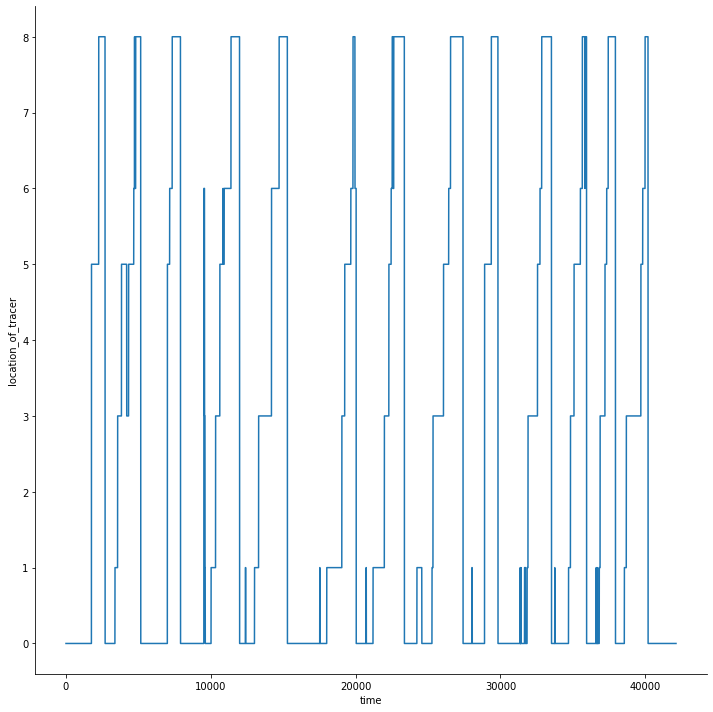

In [28]:
sns.relplot(
    data=max_signal_df,
    x=max_signal_df.time,
    y="location_of_tracer",
    kind="line",
    height=10,
)
plt.show()